
Colorization autoencoder<br>
The autoencoder is trained with grayscale images as input<br>
and colored images as output.<br>
Colorization autoencoder can be treated like the opposite<br>
of denoising autoencoder. Instead of removing noise, colorization<br>
adds noise (color) to the grayscale image.<br>
Grayscale Images --> Colorization --> Color Images<br>


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K

/Users/jonasgacrama/miniconda/envs/tf/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale.
       Source: opencv.org
       grayscale = 0.299*red + 0.587*green + 0.114*blue
    Argument:
        rgb (tensor): rgb image
    Return:
        (tensor): grayscale image
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

load the CIFAR10 data

In [5]:
(x_train, _), (x_test, _) = cifar10.load_data()

input image dimensions<br>
we assume data format "channels_last"

In [6]:
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

create saved_images folder

In [7]:
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

display the 1st 100 input images (color and gray)

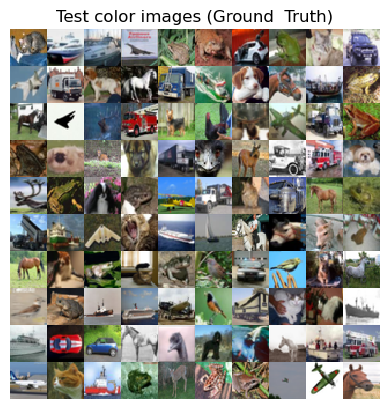

In [8]:
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

convert color train and test images to gray

In [9]:
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

display grayscale version of test images

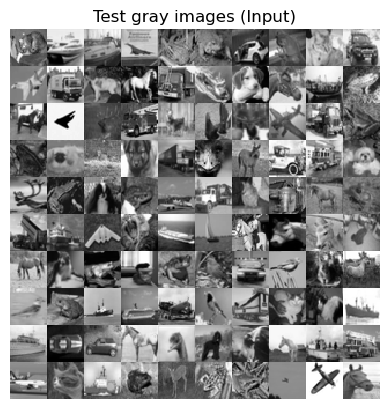

In [10]:
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()

normalize output train and test color images

In [11]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

normalize input train and test grayscale images

In [12]:
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

reshape images to row x col x channel for CNN output/validation

In [13]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)

reshape images to row x col x channel for CNN input

In [14]:
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)

network parameters

In [15]:
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

build the autoencoder model<br>
first build the encoder model

In [16]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-14 11:16:03.803674: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-14 11:16:03.803955: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


shape info needed to build decoder model so we don't do hand computation<br>
the input to the decoder's first Conv2DTranspose will have this shape<br>
shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)

In [17]:
shape = K.int_shape(x)

generate a latent vector

In [18]:
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

instantiate encoder model

In [19]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1,418,496
Trainable params: 1,418,496
Non-tra

build the decoder model

In [20]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)

In [21]:
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

In [22]:
outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

instantiate decoder model

In [23]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 64)       7379

autoencoder = encoder + decoder<br>
instantiate autoencoder model

In [24]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               1418496   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         2013315   
                                                                 
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


prepare model saving directory.

In [25]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs

In [26]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

save weights for future use (e.g. reload parameters w/o training)

In [27]:
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

Mean Square Error (MSE) loss function, Adam optimizer

In [28]:
autoencoder.compile(loss='mse', optimizer='adam')

called every epoch

In [29]:
callbacks = [lr_reducer, checkpoint]

train the autoencoder

In [30]:
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=30,
                batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/30


2022-11-14 11:16:05.319473: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-14 11:16:05.832588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 0.0156

2022-11-14 11:16:35.884275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.01109, saving model to /Users/jonasgacrama/work/Advanced-Deep-Learning-with-Keras/chapter3-autoencoders/saved_models/colorized_ae_model.001.h5
1563/1563 [==============================] - 34s 21ms/step - loss: 0.0156 - val_loss: 0.0111 - lr: 0.0010
Epoch 2/30
1561/1563 [============================>.] - ETA: 0s - loss: 0.0102
Epoch 2: val_loss improved from 0.01109 to 0.00986, saving model to /Users/jonasgacrama/work/Advanced-Deep-Learning-with-Keras/chapter3-autoencoders/saved_models/colorized_ae_model.002.h5
1563/1563 [==============================] - 32s 20ms/step - loss: 0.0102 - val_loss: 0.0099 - lr: 0.0010
Epoch 3/30
1560/1563 [============================>.] - ETA: 0s - loss: 0.0092
Epoch 3: val_loss improved from 0.00986 to 0.00895, saving model to /Users/jonasgacrama/work/Advanced-Deep-Learning-with-Keras/chapter3-autoencoders/saved_models/colorized_ae_model.003.h5
1563/1563 [==============================] - 31s 20ms/step - loss: 0.

predict the autoencoder output from test data

In [31]:
x_decoded = autoencoder.predict(x_test_gray)

 13/313 [>.............................] - ETA: 2s

2022-11-14 11:32:08.092754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 9ms/step


display the 1st 100 colorized images

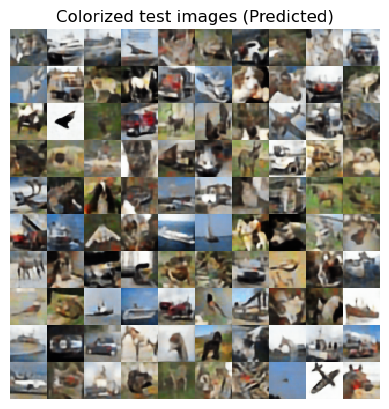

In [32]:
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()